<a href="https://colab.research.google.com/github/lygitdata/STATS-415-Project/blob/main/code/STATS_415_Kaggle_Li_Yuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Data Cleaning

In [ ]:
# Import training set
X_train = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/X_train.csv')
y_train = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/y_train.csv')
# Import testing set
X_test = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/X_test.csv')
y_sample = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/y_sample.csv')

# Dummy variable transform
categorical_cols = ['self_eval', 'teacher_eval', 'district']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
print(X_train.shape)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
print(X_test.shape)

# Drop and save SEQN
SEQN_X_train = X_train['SEQN']
X_train = X_train.drop(columns=['SEQN'])
SEQN_y_train = y_train['SEQN']
y_train = y_train.drop(columns=['SEQN'])
SEQN_X_test = X_test['SEQN']
X_test = X_test.drop(columns=['SEQN'])

# Scale data
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

# Convert data to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()

(8000, 65)
(4000, 65)


# Model Training

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.15,
    decay_steps=2000,
    decay_rate=0.9
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_r2_score',
        patience=20,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor='val_r2_score',
        mode='max'
    )
]

def build_model():
    model = Sequential([
        layers.Dense(units=4096, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(units=2048, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(units=512, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(units=1, activation='linear')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.R2Score(name='r2_score')]
    )

    return model

kf = KFold(n_splits=15, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []
i = 0
for train_index, val_index in kf.split(X_train):
    i = i + 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = build_model()
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200,
        batch_size=512,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=0
    )

    y_val_pred = model.predict(X_val_fold, verbose=False)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_val_fold, y_val_pred)
    r2_scores.append(r2)
    print(i, "Fold | Validation MSE =", round(mse, 5), " | Validation Adjusted R^2 =", round(r2, 5))

1 Fold | Validation MSE = 0.2624  | Validation Adjusted R^2 = 0.87753
2 Fold | Validation MSE = 0.27495  | Validation Adjusted R^2 = 0.87104
3 Fold | Validation MSE = 0.29078  | Validation Adjusted R^2 = 0.87421


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4 Fold | Validation MSE = 0.27448  | Validation Adjusted R^2 = 0.87777


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5 Fold | Validation MSE = 0.26518  | Validation Adjusted R^2 = 0.88224
6 Fold | Validation MSE = 0.2985  | Validation Adjusted R^2 = 0.86047


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7 Fold | Validation MSE = 0.28873  | Validation Adjusted R^2 = 0.89058
8 Fold | Validation MSE = 0.27566  | Validation Adjusted R^2 = 0.88889
9 Fold | Validation MSE = 0.28518  | Validation Adjusted R^2 = 0.88136
10 Fold | Validation MSE = 0.30197  | Validation Adjusted R^2 = 0.87877
11 Fold | Validation MSE = 0.28829  | Validation Adjusted R^2 = 0.87506
12 Fold | Validation MSE = 0.24607  | Validation Adjusted R^2 = 0.88151
13 Fold | Validation MSE = 0.27832  | Validation Adjusted R^2 = 0.88504
14 Fold | Validation MSE = 0.267  | Validation Adjusted R^2 = 0.87609


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15 Fold | Validation MSE = 0.25885  | Validation Adjusted R^2 = 0.8925


Mean MSE = 0.27709234678109973
Std Dev MSE = 0.01496788685039
Mean Adj. R^2 = 0.8795382065378229
Std Dev Adj. R^2 =  0.007855953441072521


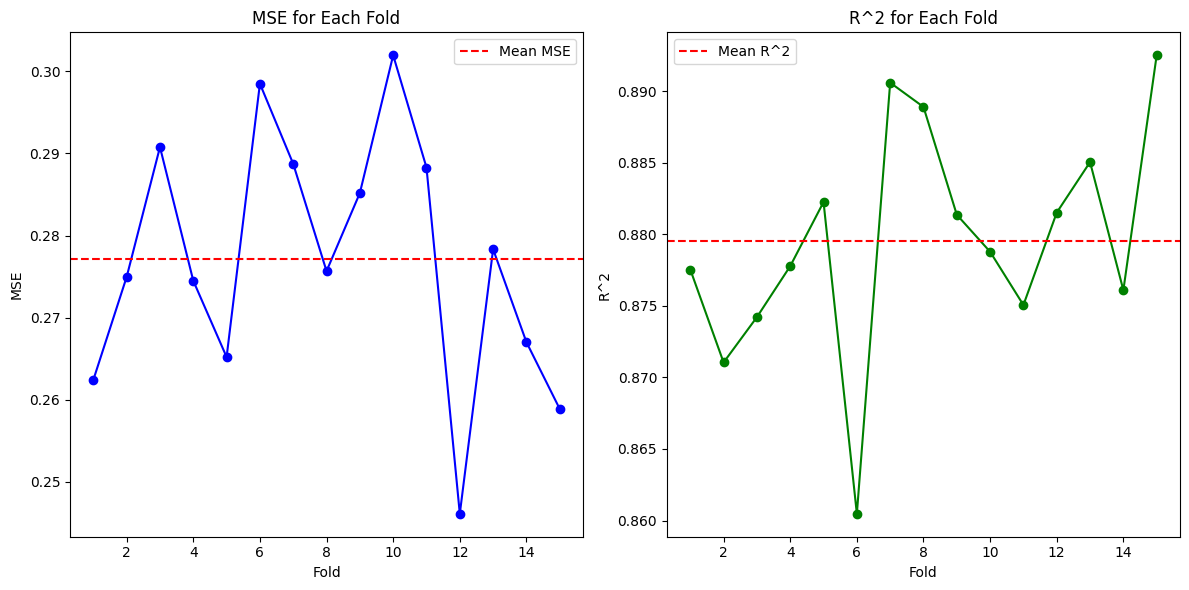

In [ ]:
print("Mean MSE =", np.mean(mse_scores))
print("Std Dev MSE =", np.std(mse_scores))
print("Mean Adj. R^2 =", np.mean(r2_scores))
print("Std Dev Adj. R^2 = ", np.std(r2_scores))

# Plot MSEs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', linestyle='-', color='b')
plt.axhline(y=np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.title('MSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

# Plot R^2s
plt.subplot(1, 2, 2)
plt.plot(range(1, len(r2_scores) + 1), r2_scores, marker='o', linestyle='-', color='g')
plt.axhline(y=np.mean(r2_scores), color='r', linestyle='--', label='Mean R^2')
plt.title('R^2 for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_temp = model.predict(X_train)
mean_squared_error(y_temp, y_train)

250/250 [==============================] - 1s 5ms/step


0.21382880624584782

In [ ]:
y_test = model.predict(X_test)
output = pd.DataFrame({'SEQN': SEQN_X_test.values.flatten(), 'y': y_test.flatten()})
out = y_sample.merge(output, on=['SEQN'], how="left")
out = out.drop(columns=['y_x'])
out = out.rename(columns={'y_y': 'y'})
out

125/125 [==============================] - 0s 2ms/step


,SEQN,y
0,492834,1.270380
1,309349,-1.464337
2,468308,-1.231864
3,838812,-2.692406
4,947936,1.048773
...,...,...
3995,971604,0.339832
3996,2790,-0.425002
3997,159210,-0.888490
3998,366040,0.317787


In [ ]:
out.to_csv('result.csv', index=False)